# Psience Examples

In [1]:
import Psience
import McUtils.Numputils as nput
import McUtils.Plots as plt
from McUtils.Data import UnitsData
import os
import numpy as np
import scipy

from Psience.Molecools import Molecule
test_dir = os.path.join(os.path.dirname(Psience.__file__), "ci", "tests", "TestData")

np.set_printoptions(linewidth=1e8, suppress=True)

In [49]:
from McUtils.Jupyter import ModuleReloader
ModuleReloader("McUtils.Plots").reload()
ModuleReloader("McUtils.Jupyter").reload()
import McUtils.Plots as plt

/Users/Mark/Documents/UW/Research/Development/venv/lib/python3.9/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [57]:
grids = [
    np.meshgrid(
        np.linspace(r, r+2*np.pi, 100),
        np.linspace(-r, -r+2*np.pi, 100),
        indexing='ij'
    )
    for r in np.linspace(0, np.pi, 10)
]
frame_data = [
    np.cos(g[0]) * np.sin(g[1])
    for g in grids
]


fig = plt.ArrayPlot(frame_data[0])
frames = [
    plt.ArrayPlot(frame, figure=fig)
    for frame in frame_data[1:]
]
fig.animate_frames(frames)

In [ ]:
from McUtils.Jupyter import X3DHTML, JHTML

JHTML.Figure(
    JHTML.Script(src='http://www.x3dom.org/download/x3dom.js'),
    JHTML.Link(rel='stylesheet', href='http://www.x3dom.org/download/x3dom.css'),
    X3DHTML.X3D(
        X3DHTML.Scene(
            JHTML.Input(type="range", value="0", min="0", max="1", step="1", cls="slider",
                        oninput="""document.getElementById("animation-frames").setAttribute("whichChoice", this.value)"""),
            X3DHTML.Switch(
                X3DHTML.Shape(
                    X3DHTML.Appearance(X3DHTML.Material(diffuseColor='red')),
                    X3DHTML.Sphere()
                ),
                X3DHTML.Shape(
                    X3DHTML.Appearance(X3DHTML.Material(diffuseColor='blue')),
                    X3DHTML.Sphere()
                ),
                whichChoice="0",
                id="animation-frames"
            )
            
        )
    ),
    width='500px',
    height='500px'
)

## Molecular Visualization

In [14]:
mol = Molecule.from_file(
    os.path.join(test_dir, "nh3.fchk"),
    internals=[
        (0, 1),
        (0, 2),
        (0, 1, 2),
        (0, 3),
        (0, 1, 3),
        (3, 0, 1, 2)
    ],
    bonds=[
        [0, 1],
        [0, 2],
        [0, 3]
    ]
)
plt, _, _ = mol.plot(backend='x3d')
plt

## Coordinate Utils

In [18]:
from McUtils.Jupyter import ModuleReloader
ModuleReloader("McUtils.Plots").reload()
ModuleReloader("Psience.Molecools").reload()
from Psience.Molecools import Molecule

anion_nitro = Molecule.from_file(
    os.path.expanduser("~/Documents/Postdoc/Projects/2DIR/freq_anion_12_11.fchk"),
    internals=[
        (4, 7),
        (5, 10),
        (6, 11),
        (0, 1, 7),
        (1, 0, 10),
        (1, 0, 11),
        (0, 1),
        (0, 7),
        (0, 10),
        (0, 11),
        (1, 7),
        (2, 0, 1),
        (3, 0, 1),
        (1, 10),
        (1, 11),
        (0, 2),
        (0, 3),
        (1, 2),
        (1, 3),
        (2, 0, 1, 3)
    ],
    bonds=[
        [0, 1],
        [0, 2],
        [0, 3],
        [0, 7],
        [0, 8],
        [0, 9],
        [1, 2],
        [1, 3],
        [1, 10],
        [1, 11],
        [2, 12],
        [3, 27],
        [4, 7],
        [5, 10],
        [6, 11],
        [8, 15],
        [8, 18],
        [8, 30],
        [9, 21],
        [9, 24],
        [9, 34],
        [12, 13],
        [12, 14],
        [12, 15],
        [15, 16],
        [15, 17],
        [18, 19],
        [18, 20],
        [18, 21],
        [21, 22],
        [21, 23],
        [24, 25],
        [24, 26],
        [24, 27],
        [27, 28],
        [27, 29],
        [30, 31],
        [30, 32],
        [30, 33],
        [34, 35],
        [34, 36],
        [34, 37]
    ]
)

In [3]:
cart_conv = anion_nitro.get_cartesians_by_internals(2)

In [ ]:
disps = [
    [r] + [0]*(cart_conv[0].shape[0]-1)
    for r in np.arange(-.5, .5, .05)
]
geoms = [
    anion_nitro.coords + np.dot(np.array(disp), cart_conv[0]).reshape(-1, 3)
    for disp in disps
]

nitrosyl, _, _ = anion_nitro.plot(geoms + list(reversed(geoms)), backend='x3d')
nitrosyl

In [ ]:
def render_frame(disp):
    return X3DGroup(anion_nitro.plot(
        anion_nitro.coords + np.dot(np.array(disp), cart_conv[0]).reshape(-1, 3), 
        backend='x3d'
    )[0].figure.to_x3d().children[0].children)

structs = [
    render_frame([r] + [0]*(cart_conv[0].shape[0]-1))
    for r in np.arange(-.3, .3, .1)
]
    

X3D(
    X3DScene(
        X3DListAnimator(
            *(structs + list(reversed(structs))[1:-1]),
            animation_duration=1
        )
    ),
    width='100%',
    height='600px'
).to_widget()

In [85]:
nitrosyl, _, _ = anion_nitro.plot(backend='x3d')
nitrosyl

In [11]:
int_conv = anion_nitro.get_internals_by_cartesians(2)
cart_conv = anion_nitro.get_cartesians_by_internals(2)
internal_tensors = nput.tensor_reexpand(cart_conv, [0, anion_nitro.potential_derivatives[1]])

In [12]:
F_internal = internal_tensors[1]
G_internal = int_conv[0].T @ np.diag(np.repeat(1 /
                                     anion_nitro.atomic_masses, 3))  @ int_conv[0]
n = 3
redund_vals, redund_tf = np.linalg.eigh(G_internal[n:, n:])
redund_modes = np.abs(redund_vals) > 1e-10
redund_tf = redund_tf[:, redund_modes]
Q_redund = np.concatenate(
    [
        np.pad(np.eye(n), [[0, redund_tf.shape[0]], [0, 0]]),
        np.pad(redund_tf, [[n, 0], [0, 0]])
    ],
    axis=1
)
F_redund = Q_redund.T @ F_internal @ Q_redund
G_redund = Q_redund.T @ G_internal @ Q_redund

In [15]:
Q_redund.shape

(20, 15)

In [17]:
cart_disp_redund = (Q_redund.T @ cart_conv[0])

In [ ]:
def render_frame(disp):
    return X3DGroup(anion_nitro.plot(
        anion_nitro.coords + np.dot(np.array(disp), cart_disp_redund).reshape(-1, 3), 
        backend='x3d'
    )[0].figure.to_x3d().children[0].children)

structs = [
    render_frame([0, 0, 0, r] + [0]*(cart_disp_redund.shape[0]-4))
    for r in np.linspace(-.3, 0, 10)
]
    

X3D(
    X3DScene(
        X3DListAnimator(
            *(structs + list(reversed(structs))),
            animation_duration=1
        )
    ),
    width='100%',
    height='600px'
).to_widget()

In [206]:
(Q_redund[:, :6] ** 2) * 100

array([[100.        ,   0.        ,   0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        , 100.        ,   0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        , 100.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   6.09998461,  40.15261899,  21.62846816],
       [  0.        ,   0.        ,   0.        ,   0.0093499 ,   1.35695374,   2.25517153],
       [  0.        ,   0.        ,   0.        ,   2.34594346,  23.47140309,  26.43712082],
       [  0.        ,   0.        ,   0.        ,   0.50982596,  10.16424204,   0.88810502],
       [  0.        ,   0.        ,   0.        ,   0.96234173,   2.41835042,   7.93096692],
       [  0.        ,   0.        ,   0.        ,   0.01890238,   0.04776283,   2.78627757],
       [  0.        ,   0.        ,   0.        ,   0.28293862,   2.28862077,   7.81601591],
       [  0.        ,   0.        ,   0.        ,   0.5523244 ,   2.20

In [201]:
freq2, nm_tf = scipy.linalg.eigh(F_redund, G_redund, type=3)
np.sqrt(freq2) * UnitsData.convert("Hartrees", "Wavenumbers")

array([ 126.95727292,  210.82572103,  266.98429126,  278.06657356,  292.92142224,  311.7749483 ,  318.29353989,  383.27316577,  559.89322328,  615.85775714,  662.07329879,  691.640496  , 1594.61289377, 1611.5225415 , 1683.49465145])

In [ ]:
nm_tf

In [199]:
G_redund[:6, :6]

array([[ 0.00007347,  0.        ,  0.        , -0.00000213,  0.00000323,  0.00000334],
       [ 0.        ,  0.00007347,  0.        ,  0.00000138,  0.00000176, -0.00000274],
       [ 0.        ,  0.        ,  0.00007347, -0.00000052, -0.0000008 ,  0.00000044],
       [-0.00000213,  0.00000138, -0.00000052,  0.00000378,  0.        , -0.        ],
       [ 0.00000323,  0.00000176, -0.0000008 ,  0.        ,  0.00000655, -0.        ],
       [ 0.00000334, -0.00000274,  0.00000044, -0.        , -0.        ,  0.00000967]])

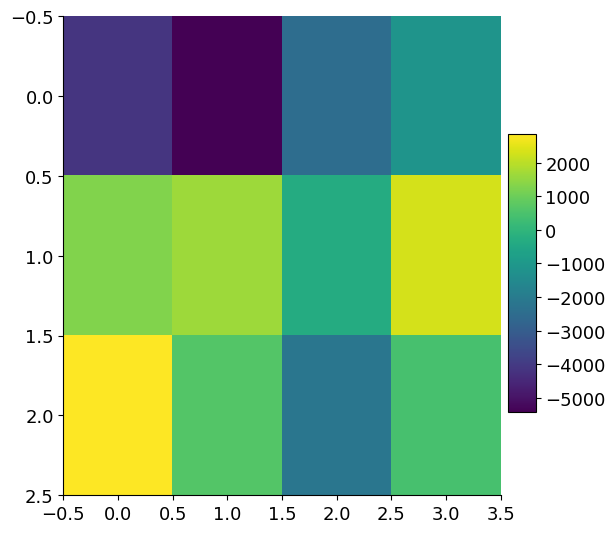

In [210]:
plt.ArrayPlot(
    F_redund[:3, 4:8] * UnitsData.convert("Hartrees", "Wavenumbers"), colorbar=True)

[1551.87525318 1512.89930708 1598.898428    362.76117619  425.53019189  540.9125101   321.65126048  433.8023248   275.72021504  406.34390107  312.68489607  596.00502816  667.84563759  784.63469641  781.02760052]


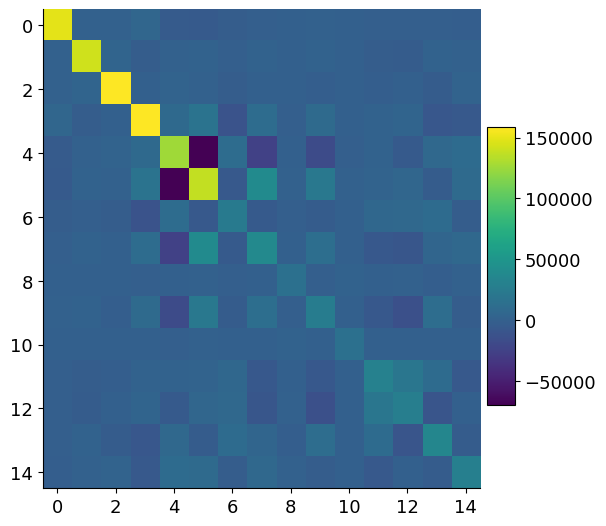

In [195]:
loc_freq = np.sqrt(np.diag(F_redund * G_redund))
print(loc_freq * UnitsData.convert("Hartrees", "Wavenumbers"))
plt.ArrayPlot(F_redund * UnitsData.convert("Hartrees",
              "Wavenumbers"), colorbar=True)

In [ ]:
loc_freq = np.sqrt(np.diag(
    internal_tensors[1] * G_internal)) * UnitsData.convert("Hartrees", "Wavenumbers")
backbone_freqs, Q_freqs = scipy.linalg.eigh(
    F_internal[3:, 3:], G_internal[3:, 3:], type=2)
print(backbone_freqs * UnitsData.convert("Hartrees", "Wavenumbers"))
print(loc_freq * UnitsData.convert("Hartrees", "Wavenumbers"))
plt.ArrayPlot(F_internal * UnitsData.convert("Hartrees",
              "Wavenumbers"), colorbar=True)

In [156]:
F_internal[:3]

array([[149349.08385137,   1417.16235467,   1247.14510068,  -6785.92274008,    500.44569654,    -71.85667296,    249.16459632,   4863.11834243,   1031.691762  ,   -193.96324099,  -1666.78180958,   -717.02616341,   -379.22641609,    384.66718403,    481.25399831,   1076.96400248,   1178.97700628,   3065.32324814],
       [  1417.16235467, 141941.37086136,   3972.7738129 ,   2080.19304407,   -675.98220776,    886.84987393,   -964.35236555,   -638.41544414,    983.32959771,    255.14852299,    446.83846429,   5874.24463196,     74.29594904,   -283.44972827,   -201.13327882,    -94.2947657 ,   -121.78096757,  -1891.1786959 ],
       [  1247.14510068,   3972.7738129 , 158537.02287136,   2444.15384774,   1315.65760939,    809.92554067,  -2914.21044732,     92.84589032,    470.12854016,   2273.7878008 ,   -428.79697089,   -239.11918075,   4483.69997573,    359.63419267,    445.65584177,    836.92354567,    761.46866017,    515.56839805]])

In [214]:
nitrosyl, _, _ = anion_nitro.plot(backend='x3d')
nitrosyl

In [ ]:
329704.77847410034
32073.705873395294

In [ ]:
plt.ArrayPlot(internal_tensors[1], colorbar=True)

In [109]:
G_nitro = np.linalg.inv(
    derivs[0] @ np.diag(np.repeat(anion_nitro.atomic_masses, 3)) @ derivs[0].T)

In [91]:
np.sqrt(np.diag(internal_tensors[1] * G_nitro)) * \
    UnitsData.convert("Hartrees", "Wavenumbers")

array([1602.33017805, 1586.88593318, 1664.60421917])

In [89]:
f2, _ = scipy.linalg.eigh(
    internal_tensors[1],
    G_nitro,
    type=2
)

In [90]:
np.sqrt(f2) * UnitsData.convert("Hartrees", "Wavenumbers")

array([1579.45556283, 1602.54360868, 1671.45154827])

In [98]:
m_inv = np.diag(1/np.repeat(np.sqrt(anion_nitro.atomic_masses), 3))
mw_F = m_inv @ anion_nitro.potential_derivatives[1] @ m_inv
np.sqrt(np.linalg.eigvalsh(mw_F)[6:]) * \
    UnitsData.convert("Hartrees", "Wavenumbers")

array([  42.69885546,   48.50022449,   53.61396474,   60.29776772,
         66.51531129,   73.55274346,   81.7311022 ,  103.98082747,
        112.24712959,  118.91899459,  129.47607522,  137.24489423,
        153.66787266,  163.13178563,  191.88394543,  212.85889614,
        220.13540973,  225.9305723 ,  236.47811242,  246.43278741,
        254.32372981,  258.30922124,  274.64123867,  279.91581781,
        293.02630906,  298.16009576,  325.95959688,  337.52618609,
        353.61766815,  363.91455962,  376.8793604 ,  406.33936568,
        410.73033406,  429.37331008,  510.09601737,  516.78300832,
        559.83353731,  564.04417009,  585.33223637,  615.42696574,
        617.11059675,  619.65041214,  664.36449825,  723.99748163,
        725.23700191,  741.31926022,  831.52053023,  853.35052242,
        898.16058941,  911.9579656 ,  926.1154229 ,  938.40101433,
        978.14302503, 1001.58663329, 1010.54966458, 1023.55274769,
       1036.36872252, 1073.25020118, 1086.94728508, 1099.83847